In [1]:
# Please visit:
#
# https://download.nkg-mn.com/credo/anomalies/
#
# Pretrained dots_100000.h5 and others can be downloaded from mentioned website.

In [2]:
from align_images_pca import align_image
from PIL import Image
import numpy as np
import glob


DOTS_SRC = 'hit-images-final2/dot'
TRACKS_SRC = 'hit-images-final2/line'
WORMS_SRC = 'hit-images-final2/worms'


def load_images(src):
    images = []
    files = list(glob.glob("%s/*.png" % src))
    files = sorted(files)
    for image_path in files:
        img = Image.open(image_path)
        img = img.convert('L')
        image = np.asarray(img)
        #image = np.asarray(Image.open(image_path).convert('L'))
        image = align_image(image)
        mask = np.where(image > 25, 1, 0)
        image = mask * image
        image = image.astype(np.float32) / np.max(image)
        image = np.expand_dims(image, 2)
        images.append(image)
    return np.asarray(images), files


dots_set, dots_files = load_images(DOTS_SRC)
tracks_set, tacks_files = load_images(TRACKS_SRC)
worms_set, worms_files = load_images(WORMS_SRC)

tracks_set = np.vstack([tracks_set, dots_set])
tacks_files = np.hstack([tacks_files, dots_files])

In [3]:
def augmentation_mirror(src, files):
    images = []
    files_aug = []
    for i in range(0, len(src)):
        img = src[i]
        images.append(img)
        images.append(np.flip(img))
        files_aug.append(files[i])
        files_aug.append(files[i])
    return np.asarray(images), files_aug


tracks2_set, tacks2_files = augmentation_mirror(tracks_set, tacks_files)
worms2_set, worms2_files = augmentation_mirror(worms_set, worms_files)

In [4]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    p = np.random.permutation(df.shape[0])
    n = int(train_percent * len(p))
    m = int(validate_percent * len(p)) + n
    train = p[:n]
    validation = p[n:m]
    test = p[m:]
    return train, validation, test


tracks2_train, tracks2_validate, tracks2_test = train_validate_test_split(tracks2_set)
worms2_train, worms2_validate, worms2_test = train_validate_test_split(worms2_set)

320
0
128
18496
0
256
0
230416
244800
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 60, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 30, 30, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 15, 15, 64)        0 

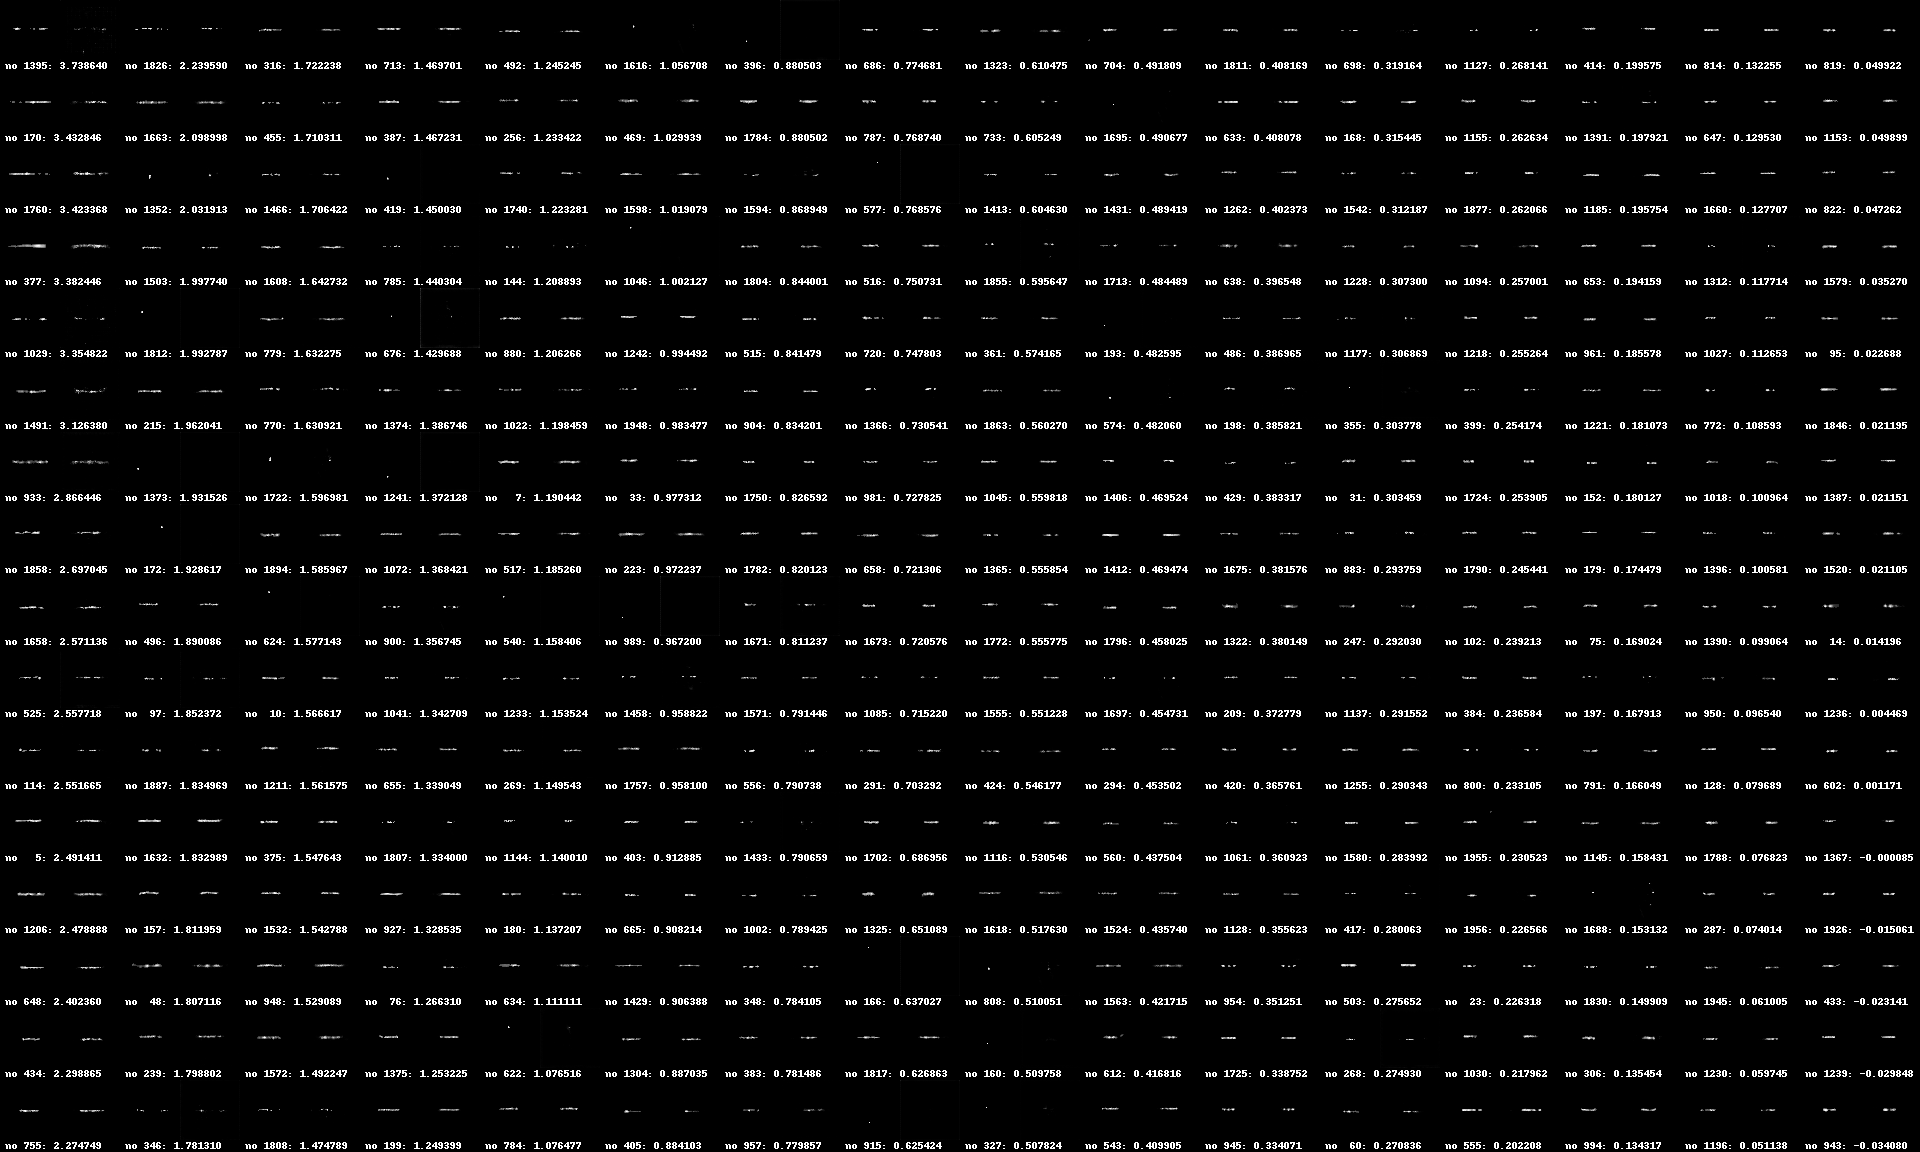

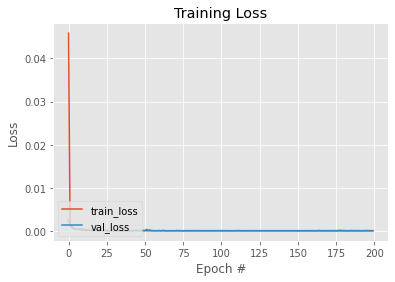

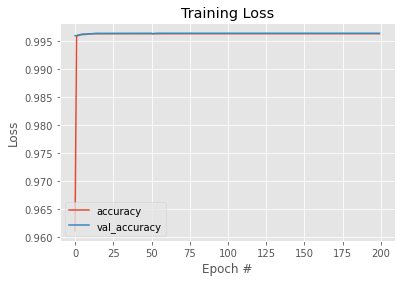

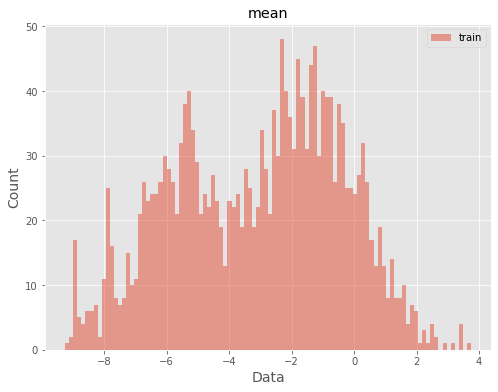

In [5]:
from commons import *
from dataset_loader import load_from_file
from IPython.display import display
import matplotlib.pyplot as plt
import cv2

#DOTS_DST = 'cache/dots_100000.pickle'
#ARTIFACTS_DST = 'cache/artifacts_100000.pickle'

#DOTS_AC = 'cache/dots_100000.h5'
TRACKS_AC = 'cache/th_dots_optics_100000.h5'
#WORMS_AC = 'cache/worms_100000.h5'
#ARTIFACTS_AC = 'cache/artifacts_100000.h5'

def train_and_test(train_set, validation_set, fn):
    autoencoder = original_autoencoder()
    autoencoder = train_or_cache(train_set, autoencoder, fn, validation_set=validation_set, force_train=True)

    for df_func, df_name in zip(
            [dm_func_mean],
            ['mean']
    ):
        for img_set, set_names in zip([validation_set], ['train']):
            decoded = autoencoder.predict(img_set)

            vis, errors = visualize_predictions(decoded, img_set, df_func, False, 16)
            img_path = fn.replace('.h5', '-vis.png')
            hist_path = fn.replace('.h5', '-hist.png')
            cv2.imwrite(img_path, vis)
            display(Image.open(img_path))
            if len(img_set) > 256:
                vis, errors = visualize_predictions(decoded, img_set, df_func, False)
                img_path = fn.replace('.h5', '-vis_full.png')
                cv2.imwrite(img_path, vis)

            plt.figure(figsize=(8,6))
            plt.hist(errors, bins=100, alpha=0.5, label=set_names)
            plt.xlabel("Data", size=14)
            plt.ylabel("Count", size=14)
            plt.title(df_name)
            plt.legend(loc='upper right')
            plt.savefig(hist_path)


train_and_test(tracks2_set[tracks2_train], tracks2_set[tracks2_validate], TRACKS_AC)

In [6]:
from keras.models import load_model

def encoder_embedding(model_file, test_set):
    encoder = load_model(model_file.replace('.h5', '-encoder.h5'))
    embedding = encoder.predict(test_set)
    #with_c = np.vstack([v, np.ones(v.shape) * c])
    #transposed = with_c.transpose()
    return embedding

In [7]:
def dbscan(embedding, t_files, eps):
    img_count = len(embedding)
    threshold = 1
    p = 16

    #for a in range(emb_array.shape[0]):
    #    emb_array[a] = emb_array[a] / w

    #emb_array_copy = np.copy(emb_array[0:img_count, 3:50])
    emb_array_copy = np.copy(embedding[0:img_count, 0:p])


    from sklearn.cluster import DBSCAN
    from sklearn import metrics
    from sklearn.datasets import make_blobs
    from sklearn.preprocessing import StandardScaler

    db = DBSCAN(min_samples=5, eps=eps).fit(emb_array_copy)
    #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    #core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    import matplotlib.pyplot as plt

    # Black removed and is used for noise instead.
    """
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = emb_array_copy[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = emb_array_copy[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )
    """
    result = np.where(labels == -1)
    my_ids = result[0]
    print(labels)
    print(my_ids)
    print(len(my_ids))


    import matplotlib.pyplot as plt


    fig = plt.figure(figsize=(32, 32))
    columns = 5
    rows = int(len(my_ids) / 5) + 1

    for aaa in range(len(my_ids)):
        #img_help = cv2.imread('d:\\dane\\credo\\png\\' + all_files_names[my_ids[aaa]])
        img_help = cv2.imread(t_files[my_ids[aaa]])
        print(t_files[my_ids[aaa]])

        aaa1 = aaa + 1
        xxxxx = (aaa % 5) + 1
        r = fig.add_subplot(rows, columns, aaa1)
        r.axis("off")
        plt.imshow(img_help)
        #cv2.imshow(str(aaa), img_help)
        #print(all_files_names[my_ids[0]])

    plt.show()


[0 0 0 ... 0 0 0]
[  27   29   36   58   72   76   78   86  174  182  191  192  215  230
  231  247  297  309  325  354  356  358  389  390  422  431  435  437
  446  462  495  499  530  552  580  618  638  640  647  650  668  679
  697  716  732  764  771  793  796  830  879  881  887  892  895  908
  931  937  981  987 1027 1038 1059 1068 1110 1117 1121 1125 1136 1174
 1203 1213 1257 1268 1269 1272 1367 1390 1392 1400 1424 1457 1484 1496
 1498 1499 1511 1539 1541 1547 1610 1620 1630 1631 1641 1642 1688 1692
 1695 1714 1733 1734 1740 1760 1774 1775 1787 1831 1834 1844 1862 1868
 1909 1912 1952 1972]
116
hit-images-final2/line\11820156.png
hit-images-final2/line\23930988.png
hit-images-final2/line\22035973.png
hit-images-final2/line\23655639.png
hit-images-final2/line\23777235.png
hit-images-final2/line\23517507.png
hit-images-final2/line\23072383.png
hit-images-final2/line\22605713.png
hit-images-final2/line\24205869.png
hit-images-final2/line\23071157.png
hit-images-final2/line\16053

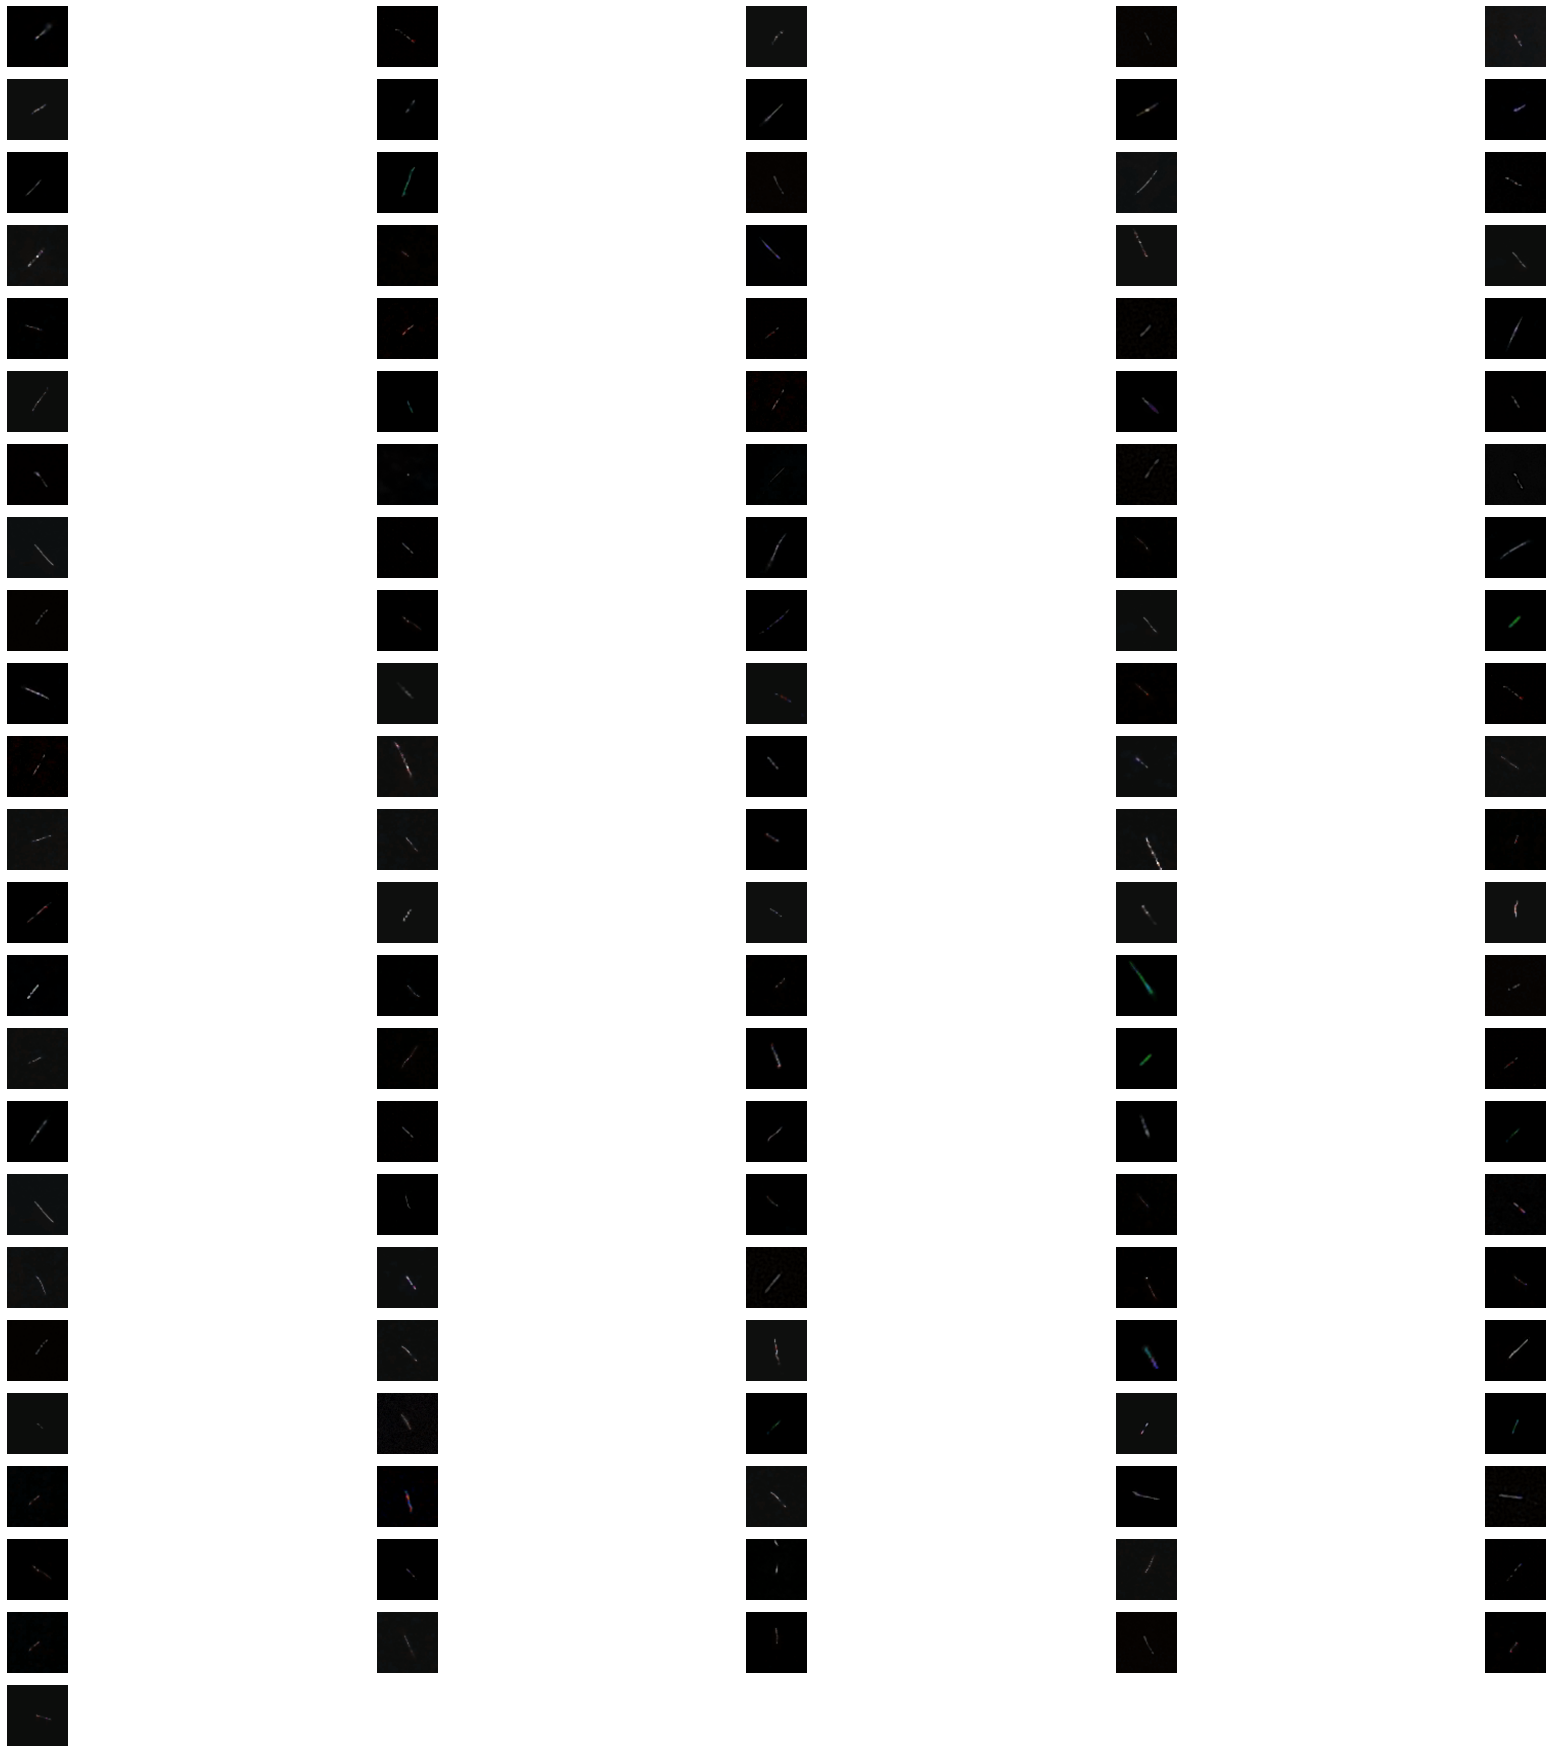

In [8]:
tracks_embedding = encoder_embedding(TRACKS_AC, tracks2_set[tracks2_test])
tracks_t_files = np.asarray(tacks2_files)[tracks2_test]
dbscan(tracks_embedding, tracks_t_files, 120)

[ 0  0  0 ... -1  0  0]
[  78   86  192  215  230  231  309  354  358  389  552  580  650  668
  679  697  793  879  881  895  981 1068 1117 1121 1136 1213 1268 1367
 1392 1400 1541 1547 1610 1631 1641 1740 1774 1775 1831 1862 1909 1912
 1981 1982 1983 1987 1991 1992 1995 1996 1999 2001 2002 2008 2009 2010
 2015 2020 2022 2029 2030 2033 2035 2036 2038 2039 2041 2044 2048 2052
 2057 2058 2061 2062 2063 2067 2069 2071 2073 2074 2077 2080 2081 2082
 2085 2087 2095 2096 2099 2100 2103 2106 2108 2110 2111 2112 2114 2115
 2117 2118 2119 2122 2125 2130 2131 2133 2136 2138 2140 2141 2145 2152
 2154 2156 2159 2161 2162 2164 2166 2169 2172]
121
hit-images-final2/line\23072383.png
hit-images-final2/line\22605713.png
hit-images-final2/line\14276151.png
hit-images-final2/line\22177963.png
hit-images-final2/line\11802060.png
hit-images-final2/line\23300748.png
hit-images-final2/line\22174636.png
hit-images-final2/line\13842344.png
hit-images-final2/line\23769959.png
hit-images-final2/line\23764899.p

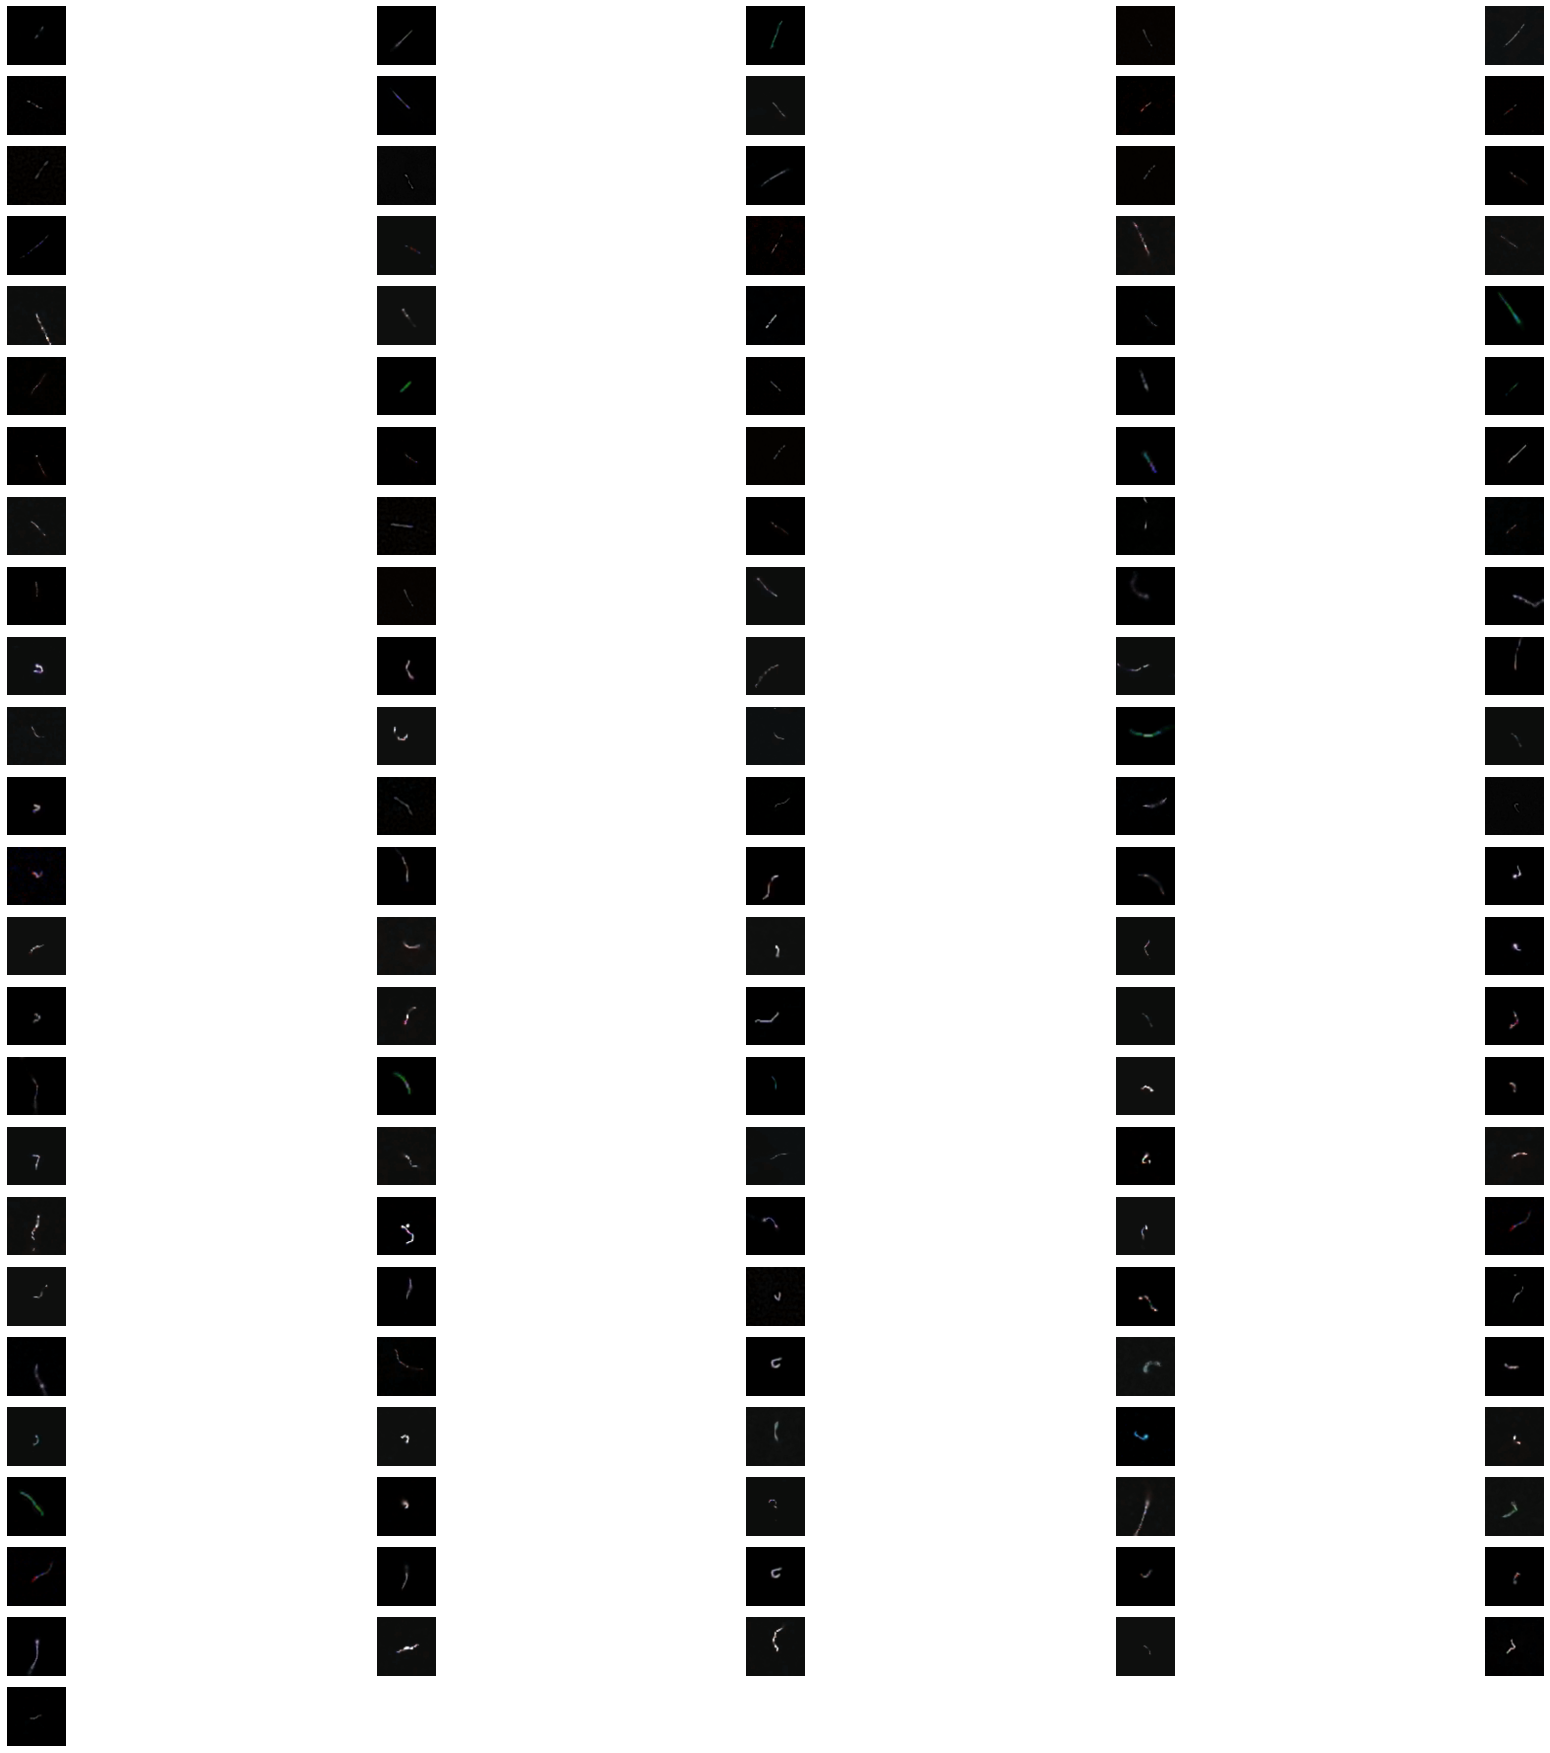

In [9]:
worms_embedding = encoder_embedding(TRACKS_AC, worms2_set[worms2_test])
worms_t_files = np.asarray(worms2_files)[worms2_test]

embedding = np.vstack([tracks_embedding, worms_embedding])
t_files = np.hstack([tracks_t_files, worms_t_files])

dbscan(embedding, t_files, 140)

[ 0  0  0 ...  0  0 -1]
[  86  192  230  354  358  389  552  650  679  793  881 1068 1117 1136
 1213 1268 1392 1424 1610 1631 1641 1740 1775 1831 1862 1912 1976]
27
hit-images-final2/line\22605713.png
hit-images-final2/line\14276151.png
hit-images-final2/line\11802060.png
hit-images-final2/line\13842344.png
hit-images-final2/line\23769959.png
hit-images-final2/line\23764899.png
hit-images-final2/line\22508283.png
hit-images-final2/line\23740643.png
hit-images-final2/line\22031347.png
hit-images-final2/line\22345563.png
hit-images-final2/line\11813671.png
hit-images-final2/line\22680462.png
hit-images-final2/line\23375637.png
hit-images-final2/line\22391783.png
hit-images-final2/line\22031454.png
hit-images-final2/line\23415595.png
hit-images-final2/line\22039573.png
hit-images-final2/line\11864308.png
hit-images-final2/line\23278286.png
hit-images-final2/line\22490031.png
hit-images-final2/line\17223488.png
hit-images-final2/line\23769522.png
hit-images-final2/line\22031347.png
hit-ima

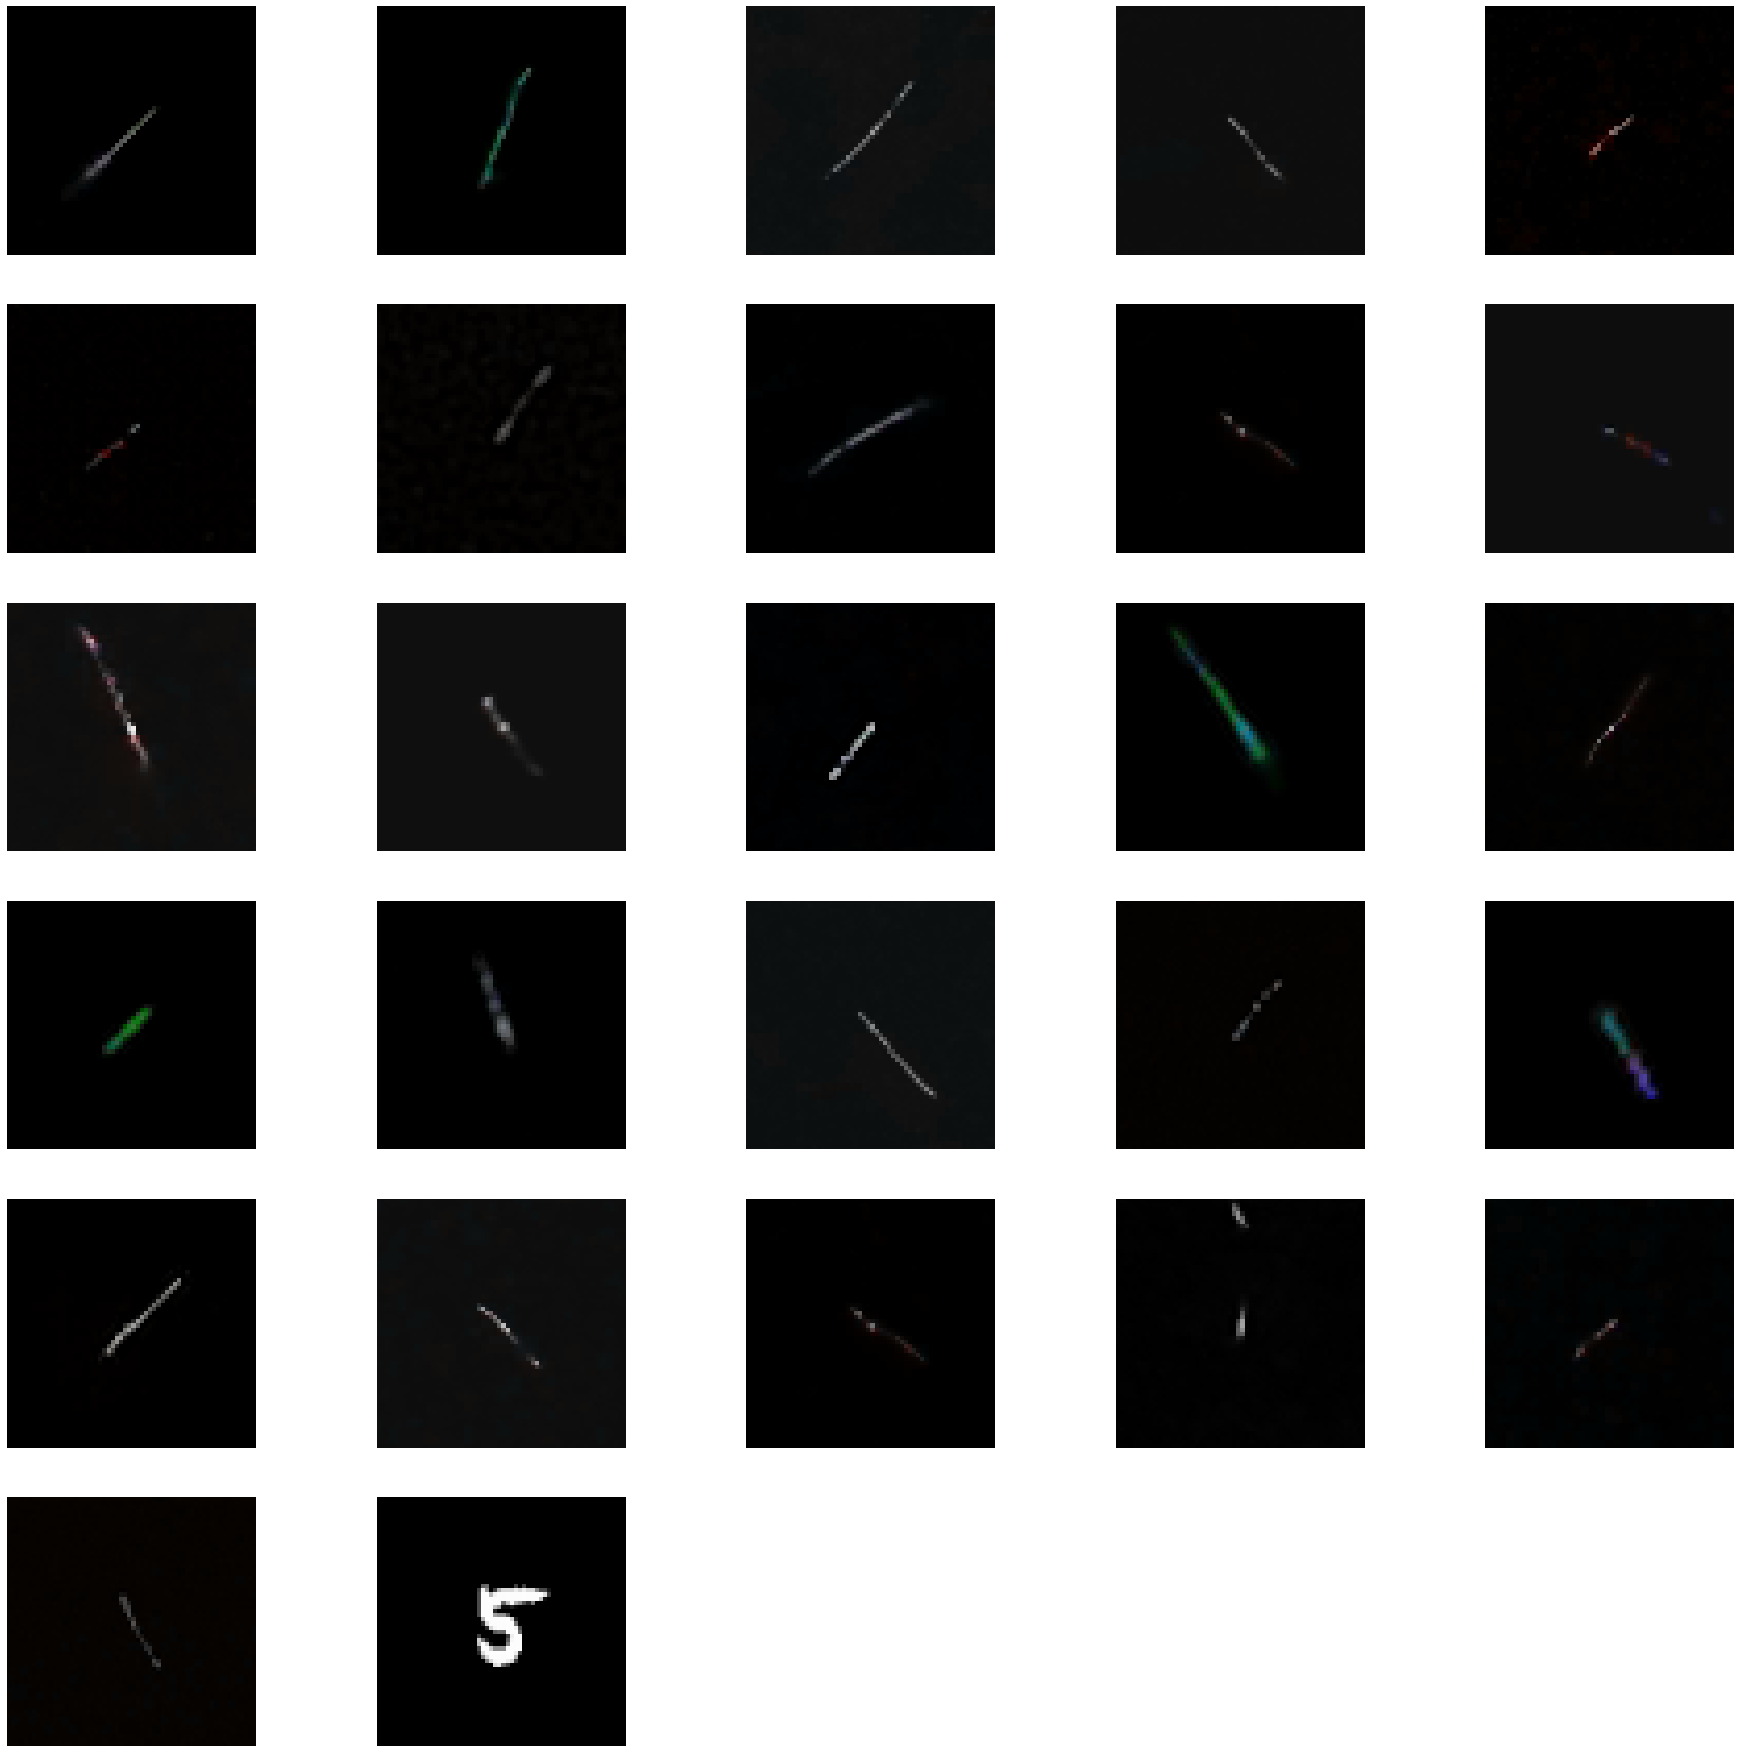

In [10]:
me_set, me_files = load_images('hit-images-final2/me')
me_embedding = encoder_embedding(TRACKS_AC, me_set)
me_files = np.asarray(me_files)

embedding = np.vstack([tracks_embedding, me_embedding])
t_files = np.hstack([tracks_t_files, me_files])

dbscan(embedding, t_files, 150)

In [11]:
def optics(embedding, t_files, eps):
    img_count = len(embedding)
    threshold = 1
    p = 16

    #for a in range(emb_array.shape[0]):
    #    emb_array[a] = emb_array[a] / w

    #emb_array_copy = np.copy(emb_array[0:img_count, 3:50])
    emb_array_copy = np.copy(embedding[0:img_count, 0:p])


    from sklearn.cluster import OPTICS
    from sklearn import metrics
    from sklearn.datasets import make_blobs
    from sklearn.preprocessing import StandardScaler

    db = OPTICS(min_samples=5, cluster_method='dbscan', eps=eps).fit(emb_array_copy)
    #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    #core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    import matplotlib.pyplot as plt

    # Black removed and is used for noise instead.
    """
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = emb_array_copy[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = emb_array_copy[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )
    """
    result = np.where(labels == -1)
    my_ids = result[0]
    print(labels)
    print(my_ids)
    print(len(my_ids))


    import matplotlib.pyplot as plt


    fig = plt.figure(figsize=(32, 32))
    columns = 5
    rows = int(len(my_ids) / 5) + 1

    for aaa in range(len(my_ids)):
        #img_help = cv2.imread('d:\\dane\\credo\\png\\' + all_files_names[my_ids[aaa]])
        img_help = cv2.imread(t_files[my_ids[aaa]])
        print(t_files[my_ids[aaa]])

        aaa1 = aaa + 1
        xxxxx = (aaa % 5) + 1
        r = fig.add_subplot(rows, columns, aaa1)
        r.axis("off")
        plt.imshow(img_help)
        #cv2.imshow(str(aaa), img_help)
        #print(all_files_names[my_ids[0]])

    plt.show()

[0 0 0 ... 0 0 0]
[  86  389  552  650  679 1117 1213 1610 1631 1641 1740 1775 1831 1912]
14
hit-images-final2/line\22605713.png
hit-images-final2/line\23764899.png
hit-images-final2/line\22508283.png
hit-images-final2/line\23740643.png
hit-images-final2/line\22031347.png
hit-images-final2/line\23375637.png
hit-images-final2/line\22031454.png
hit-images-final2/line\23278286.png
hit-images-final2/line\22490031.png
hit-images-final2/line\17223488.png
hit-images-final2/line\23769522.png
hit-images-final2/line\22031347.png
hit-images-final2/line\23742800.png
hit-images-final2/line\22177963.png


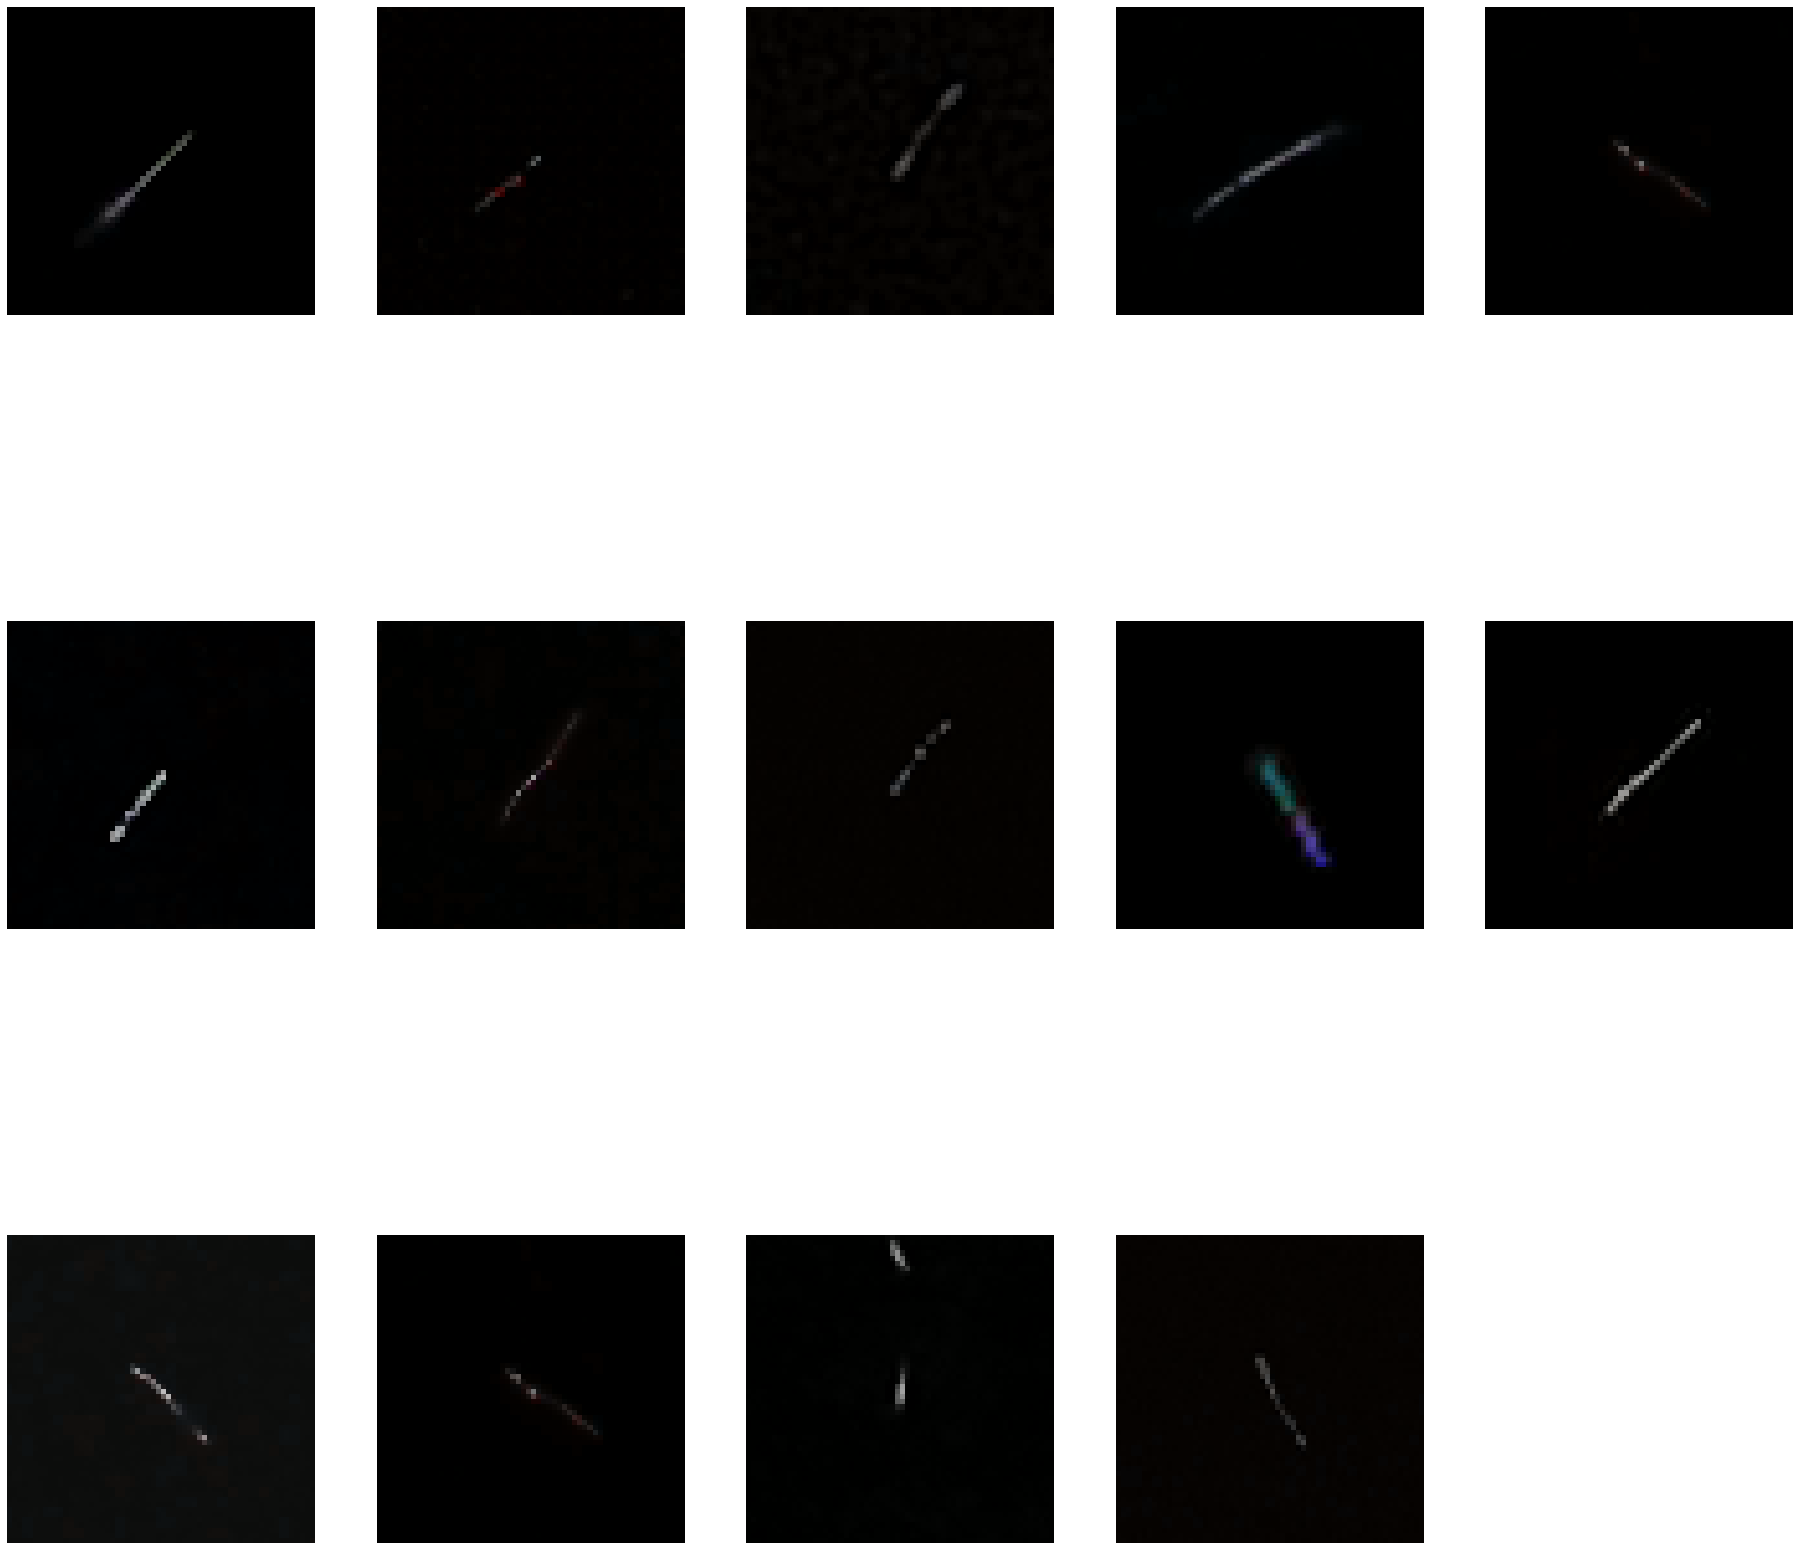

In [24]:
tracks_embedding = encoder_embedding(TRACKS_AC, tracks2_set[tracks2_test])
tracks_t_files = np.asarray(tacks2_files)[tracks2_test]
optics(tracks_embedding, tracks_t_files, 155)

[0 0 0 ... 0 0 0]
[1995 2008 2057 2077 2082 2087 2095 2096 2103 2106 2111 2117 2122 2133
 2141 2161 2162 2164 2169]
19
hit-images-final2/worms\22442473.png
hit-images-final2/worms\22437067.png
hit-images-final2/worms\22438955.png
hit-images-final2/worms\22437786.png
hit-images-final2/worms\11856737.png
hit-images-final2/worms\22013151.png
hit-images-final2/worms\11823391.png
hit-images-final2/worms\22449196.png
hit-images-final2/worms\22037705.png
hit-images-final2/worms\22426125.png
hit-images-final2/worms\13836130.png
hit-images-final2/worms\22114707.png
hit-images-final2/worms\22007747.png
hit-images-final2/worms\22214072.png
hit-images-final2/worms\22436644.png
hit-images-final2/worms\22504629.png
hit-images-final2/worms\11892077.png
hit-images-final2/worms\22484369.png
hit-images-final2/worms\22054590.png


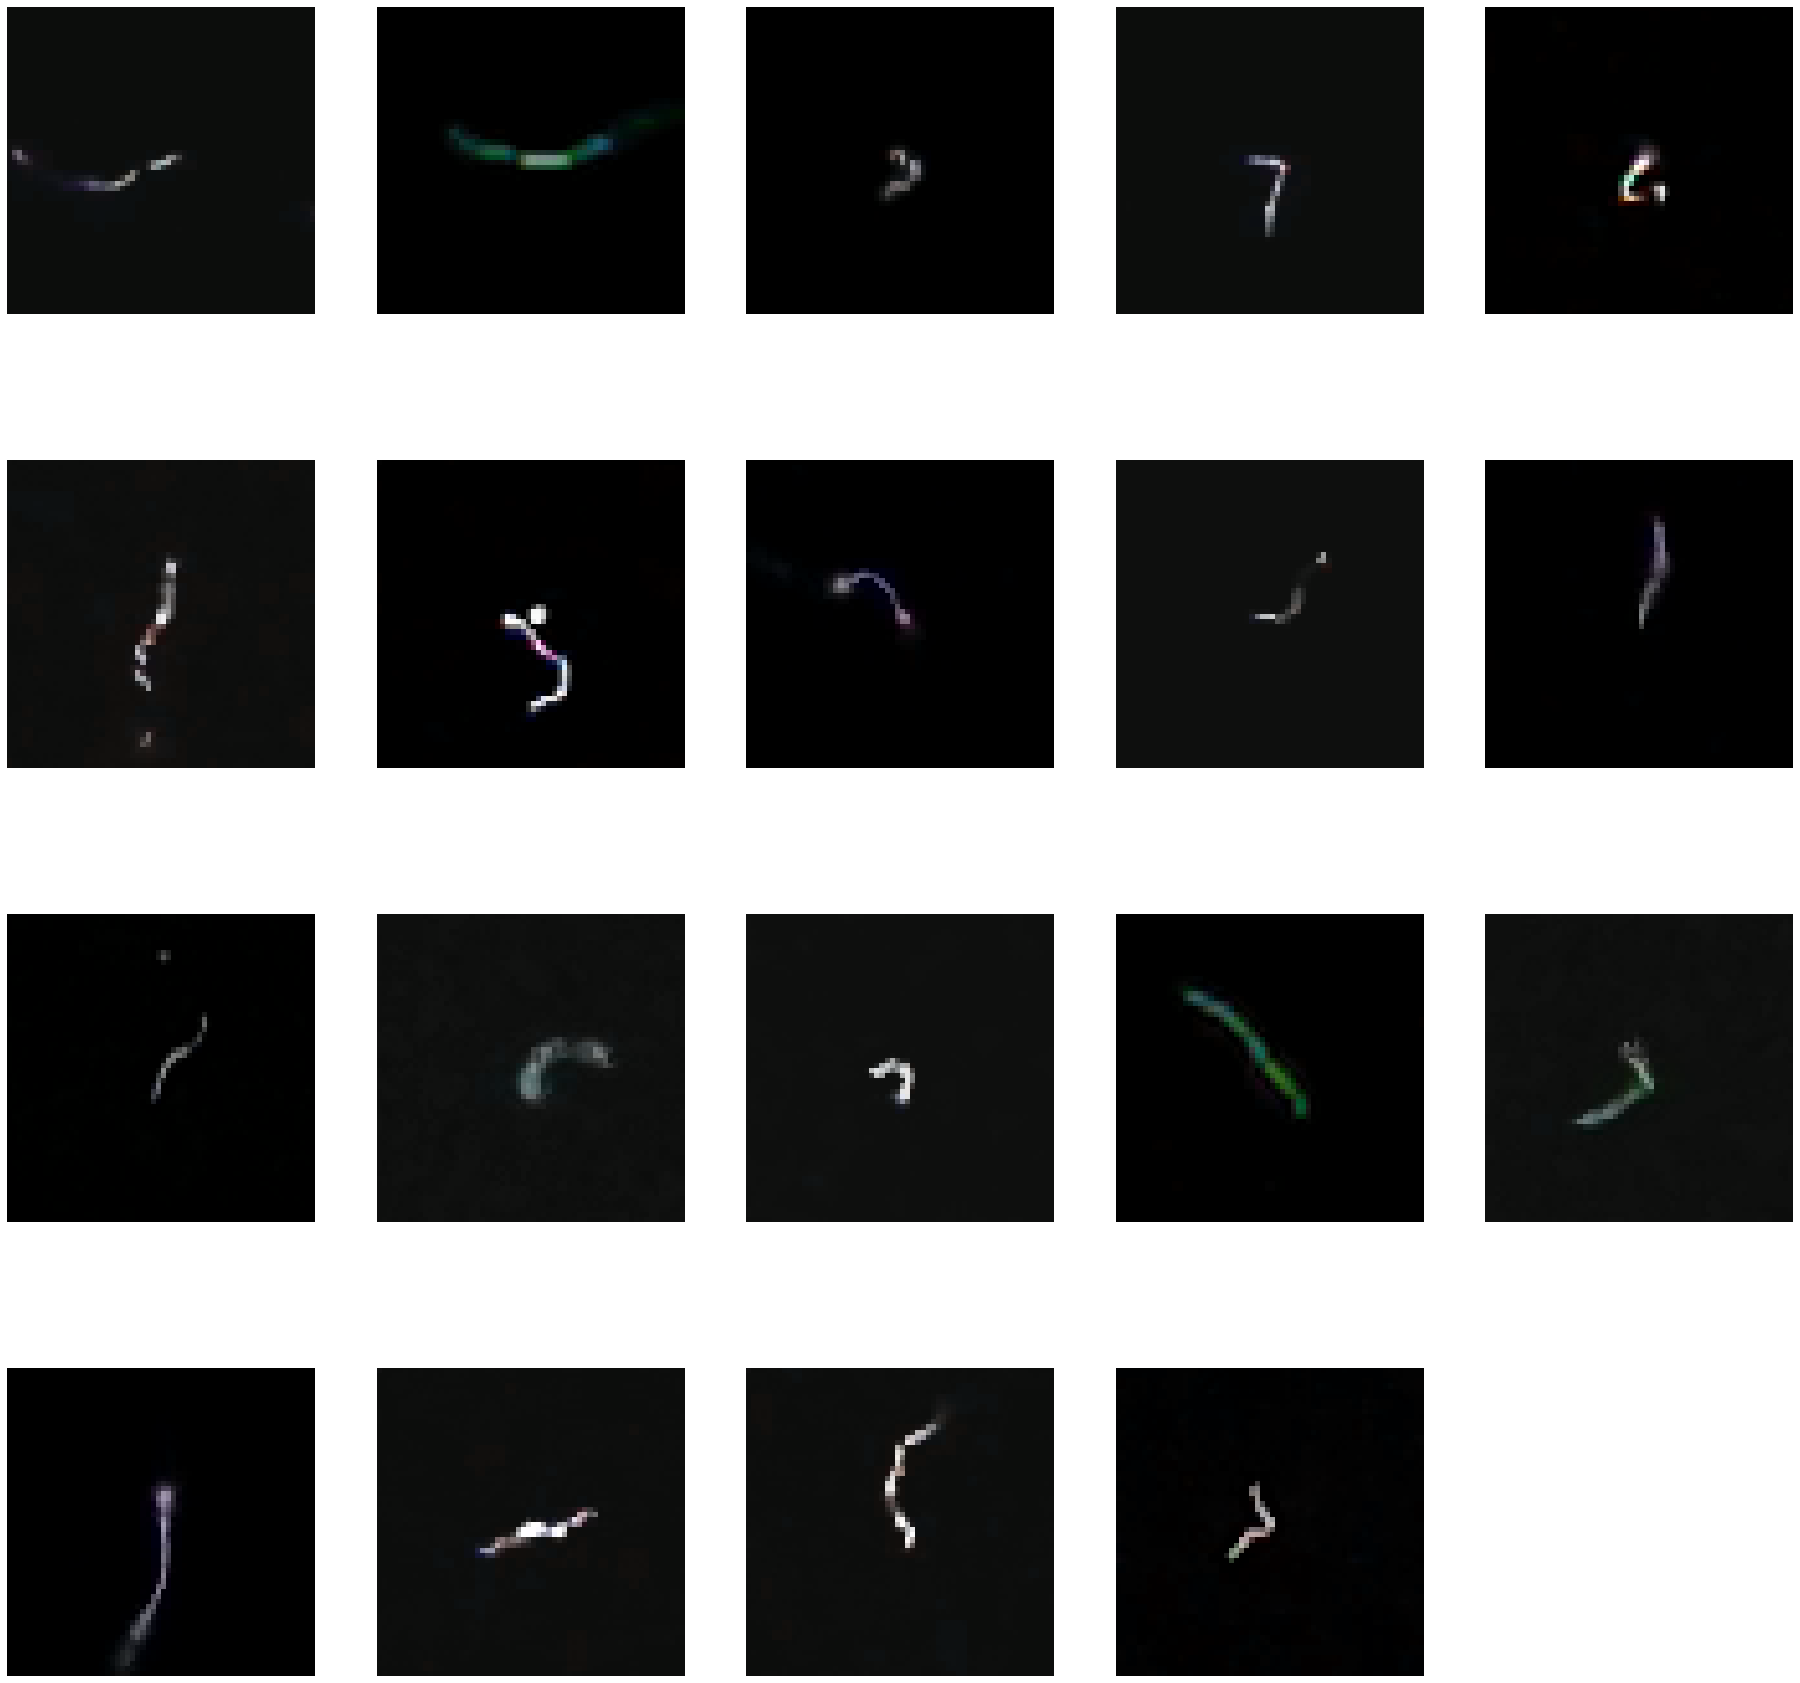

In [19]:
worms_embedding = encoder_embedding(TRACKS_AC, worms2_set[worms2_test])
worms_t_files = np.asarray(worms2_files)[worms2_test]

embedding = np.vstack([tracks_embedding, worms_embedding])
t_files = np.hstack([tracks_t_files, worms_t_files])

optics(embedding, t_files, 180)

[ 0  0  0 ...  0  0 -1]
[1976]
1
hit-images-final2/me\6044.png


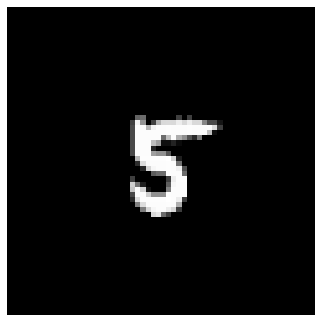

In [17]:
me_set, me_files = load_images('hit-images-final2/me')
me_embedding = encoder_embedding(TRACKS_AC, me_set)
me_files = np.asarray(me_files)

embedding = np.vstack([tracks_embedding, me_embedding])
t_files = np.hstack([tracks_t_files, me_files])

optics(embedding, t_files, 190)